In [26]:
# Ici je vais tenter de faire une régression linéaire pour prédire le temps de trajet des taxis
# Je tente une régression linéaire car c'est le seul truc qu'on a vu en cours avec le clusterring, sauf que le clustering c'est pour quand on veut prédire dans quel groupe sera une donnée (genre tumeure maligne ou bénigne). Là on veut prédire une donnée continue (un temps) et donc on a vu que la régression linéaire
# Pour faire une régression linéaire il faut s'assurer qu'il existe une relation linéaire entre les variables que l'on a en entrée et les variables que l'on veut prédire (je l'ai vu internet... :D https://datatofish.com/multiple-linear-regression-python/) donc comme dans le tuto je fais des diagrammes

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Lecture du fichier, suppression des données manquante et des données dupliquées
df = pd.read_csv("train.csv",engine='c',memory_map=True,nrows=1000)
df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)

# On remet les dates dans un format normalisée
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)

In [28]:
# Création d'une fonction qui calcule la distance haversine entre deux points (la distance est calculée à vole d'oiseau) ça je l'ai pris du deuxième notebook de Kaggle (j'ai changé l'ordre des paramètres comme ça, ça passe incognito). Ca à l'air compliqué et je n'ai aucune idée de pourquoi ça marche mais comme la Terre et ronde et que ça utilise le rayon de la Terre et de la trigo moi ça me convient
def heversine (lat1, lat2, lng1, lng2):
    lat1, lat2, lng1, lng2 = map(np.radians, (lat1, lat2, lng1, lng2))
    AVERAGE_EARTH_RADIUS = 6371#km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVERAGE_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# Par une magie inconnue df.loc[:, <nom de colonne>] créée une autre colonne donc je créé une colonne avec les distances
df.loc[:, 'distance_haversine'] = heversine(df.pickup_latitude.values, df.dropoff_latitude.values, df.pickup_longitude.values, df.dropoff_longitude.values)

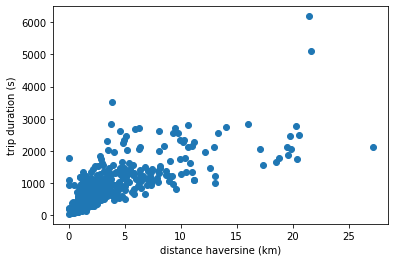

In [29]:
# Dans les graphiques je n'affiche que les 500 premières valeurs parce que il y en a quelques unes qui sont chiantes et qui font un point trèèèèèèèèèèès loin du coup on ne voit plus rien

# Le temps de trajet en fonction de la distance
plt.scatter(df[:500].distance_haversine.values, df[:500].trip_duration.values)
plt.ylabel('trip duration (s)')
plt.xlabel('distance haversine (km)')
plt.show()

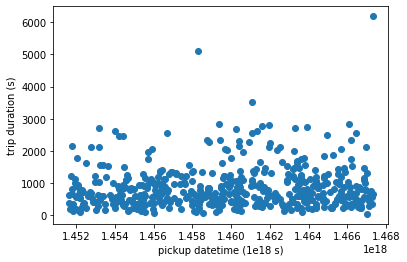

In [30]:
# Le temps de trajet en fonction de la date
plt.scatter(pd.to_numeric(df.pickup_datetime)[:500].values, df[:500].trip_duration.values)
plt.ylabel('trip duration (s)')
plt.xlabel('pickup datetime (1e18 s)')
plt.show()

# Ca n'a pas du tout l'air linéaire, on va modifier un peu les données de la date et voir ce que l'on peut en tirer

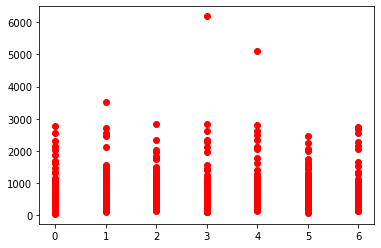

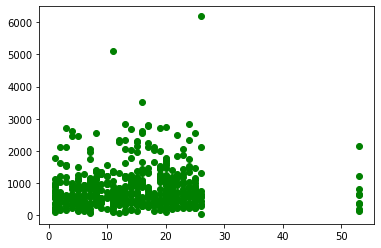

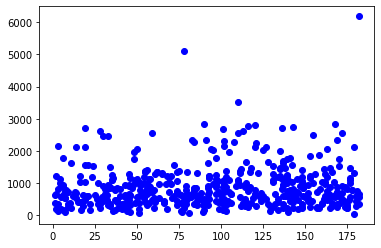

In [31]:
df.loc[:, 'time'] = df.pickup_datetime.dt.time
df.loc[:, 'dayOfWeek'] = df.pickup_datetime.dt.dayofweek
df.loc[:, 'weekOfYear'] = df.pickup_datetime.dt.weekofyear
df.loc[:, 'dayOfYear'] = df.pickup_datetime.dt.dayofyear

plt.scatter(df[:500].dayOfWeek, df[:500].trip_duration, c='red')
plt.show()

plt.scatter(df[:500].weekOfYear, df[:500].trip_duration, c='green')
plt.show()

plt.scatter(df[:500].dayOfYear, df[:500].trip_duration, c='blue')
plt.show()
# On ne trouve pas vraiment de ralation de linéarité

trip_duration ~ 569.112358835094 + 105.54373191538822 * distance_haversine


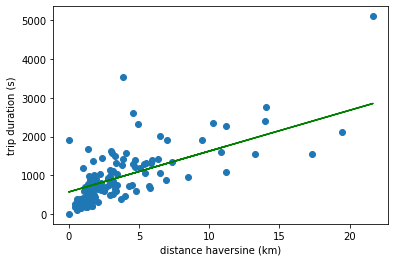

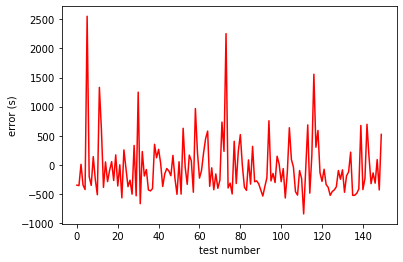

In [32]:
# Pour commencer je vais essayer de faire une régression linéaire en utilisant la donnée qui à l'air à peu près corélées linéairement avec le temps de trajet: la distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[['distance_haversine']].values
Y = df.trip_duration.values

# On sépare les données en ensemble de données test et données d'entraînement. Les données d'entraînement représenteront environ 85% des données totales. J'ai vu un cours sur Kaggle qui disait que c'était une bonne pratique de renseigné le random state afin d'avoir une bonne reproductibilité
XTrain, XTest, YTrain, YTest = train_test_split(X,Y,train_size=0.85,random_state=19061996)

reg = LinearRegression().fit(XTrain, YTrain)

# On affiche quelques informations sur la régression
print ('trip_duration ~',reg.intercept_, '+', reg.coef_[0], '* distance_haversine')

# On affiche un graphique sur ce que nous donne la régression sur des données de test par rapport aux données réelles
plt.scatter(XTest,YTest)
plt.plot(XTest,reg.predict(XTest),c='green',label='prediction')
plt.ylabel('trip duration (s)')
plt.xlabel('distance haversine (km)')
plt.show()

# On affiche l'erreur que l'on fait sur chaque prédiction
plt.plot(np.arange(len(XTest)),(YTest - reg.predict(XTest)),c='red',label='error')
plt.ylabel('error (s)')
plt.xlabel('test number')
plt.show()

# Bon ce n'est pas ouf mais c'est déjà un début. Maintenant il faut voir comment prendre en compte les autres données qui ne sont pas corrélées linéairements et je ne sais pas encore comment faire. Voire même si on peut en trouver d'autres (sur Kaggle il prennent la vitesse et tout et tout). Il va falloir continuer à éplucher ce que les gens ont fait sur Kaggle mais j'ai l'impression qu'ils utilisent tous du boosting.

In [33]:
# On calcule l'erreur (là je suis le cours sur Kaggle, je suis tombé dessus par hasard: https://www.kaggle.com/learn/intro-to-machine-learning)
from sklearn.metrics import mean_absolute_error
predictedValue = reg.predict(XTest)
print(mean_absolute_error(YTest,predictedValue))

testPrediction = reg.predict(XTest)
print(YTest[:6])
print(testPrediction[:6])

# L'erreur est en moyenne de 361.2s ce qui n'est vraiment pas ouf

364.7594805105267
[ 323  361 1356  357  272 3528]
[ 671.78762398  716.15385912 1346.31919683  704.48511959  695.33316111
  975.01869189]
